# Курсовая работа
## Задание K-3-07. Расчёт движения автомобиля

### Исходные данные
Автомобиль массы $M$, поддерживаемый пружиной с демпфером, перемещается с постоянной
горизонтальной скоростью. В момент времени $t = 0$ вертикальная скорость отсутствует. В
дальнейшем вертикальное смещение дороги от основного уровня описывается функцией
$x_0(t) = 2 (1 - cos7t)$. Предположим, что пружина - линейная с коэффициентом упругости $K$, а
коэффициент демпфирования $r$ является нелинейной функцией относительно двух концов
демпфера:

\begin{equation}
    r = r_0 \Big(1+ c \Big| \frac{dx}{dt} - \frac{dx_0}{dt} \Big| \Big)
\end{equation}

Легко показать, что смещение $x(t)$ центра тяжести автомобиля описывается уравнением:

\begin{equation}
   M\frac{d^2x}{dt^2} = -k (x - x_0(t)) - r \Big( \frac{dx}{dt} - \frac{dx_0(t)}{dt} \Big), \text{    } 0 \le t \le t_{max}
\end{equation}

С начальными условиями $x(0) = 0$, $x'_t(0) = 0$, $t_{max} = 4$ секунды

Значения $c^1$, $c^2$ и $c^3$ являются решением системы уравнений:

\begin{equation}
    \begin{pmatrix}
        46 & 42 & 24 \\
        42 & 49 & 18 \\
        24 & 18 & 16 \\
    \end{pmatrix}
    \cdot
    \begin{pmatrix}
        c^1 \\
        c^2 \\
        c^3 \\
    \end{pmatrix}
    =
    \begin{pmatrix}
        282 \\
        229 \\
        178 \\
    \end{pmatrix}
\end{equation}

$K$ равно:

\begin{equation}
    K = 1235.802 \cdot \int_0^{0.5} \sqrt{\frac{1 - 0.25 x^2}{1 - x^2}} dx
\end{equation}

$M = 25.0449 \cdot x^*$, где $x^*$ - наименьший ненулевой корень уравнения:

\begin{equation}
    2^x - 2x - 1 = 0
\end{equation}

$r_0^1 = 80$, $r_0^2 = 160$ и $r_0^3 = 240$
### Задания
1) Исследовать качество трёх демпферов: $(r_0^1, c^1)$, $(r_0^2, c^2)$, $(r_0^3, c^3)$.

2) Оценить общую погрешность результатов.

3) Варьируя значение $K$ на 5% и значение $M$ на 10%, оценить влияние на точность погрешности исходных данных.

### Выполнение работы

Для начала вычислим значения $c^1$, $c^2$, $c^3$, $M$ и $K$:

In [63]:
from numpy.linalg import solve

A = [[46, 42, 24],\
     [42, 49, 18], [24, 18, 16]]
b = [282, 229, 178]
x = solve(A, b)
i = 0
for c in x:
    print('c{i} = {c}'.format(i=i, c=c))
    i += 1

c0 = -2.0273637840981118e-16
c1 = 1.0000000000000002
c2 = 10.0


In [64]:
from scipy.optimize import brentq

M = brentq(lambda x: pow(2, x) - 2 * x - 1, 1, 3)
M *= 25.0449
print('M = {M}'.format(M=M))

M = 66.61595721485934


In [65]:
from scipy.integrate import quad

from math import sqrt

K, err = quad(lambda x: sqrt((1 - 0.25 * x * x) / (1 - x * x)), 0, 0.5)
K *= 1235.802
print('K = {K}'.format(K=K))
print('error = {err}'.format(err=err))

K = 639.9995308637812
error = 5.7496444811892876e-15


Теперь перейдём к решению дифференциального уравнения. Оно второго порядка.

Для начала приведем его к системе из двух уравнений первого порядка при помощи подстановок $y_1(t) = x(t)$ и $y_2(t) = \frac{dx}{dt}$:

\begin{equation}
    \begin{cases}
        y_1'(t) = y_2(t)
        \\
        y_2'(t) = -\frac{K}{M} \Big(y_1(t) - 2(1 - cos7t) \Big) - \frac{r_0}{M} \Big(1 + c \cdot \Big| y_2(t) - 14sin7t \Big| \Big) \Big( y_2(t) - 14sin7t \Big)
    \end{cases}
\end{equation}

In [66]:
from math import sin, cos

def fun(y, t, r, c, k, m):
    return [y[1],\
            -k/m * (y[0] - 2 * (1 - cos(7 * t))) - r/m * (1 + c * abs(y[1] - 14 * sin(7 * t)) * (y[1] - 14 * sin(7 * t)))]

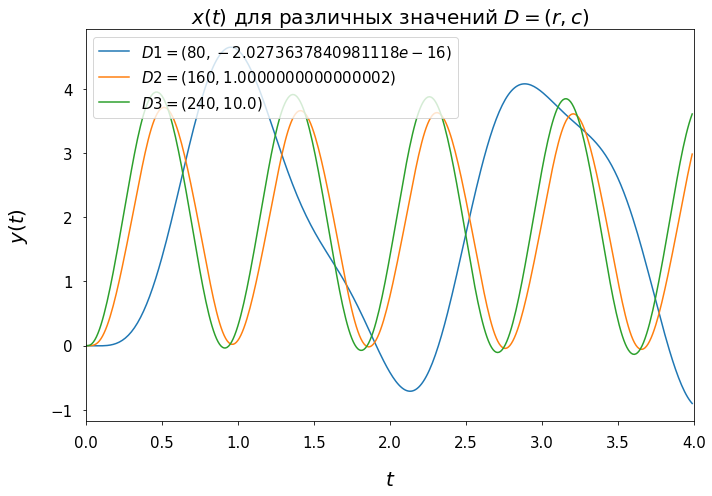

In [68]:
from numpy import arange, transpose

from scipy.integrate import odeint

import math
import numpy as np
import matplotlib.pyplot as plt

class Dempfer:
    r : float   
    c : float
    
    def __init__(self, c : float, r : float):
        self.r = r
        self.c = c
    
    def __str__(self):
        return '({r}, {c})'.format(r=self.r, c=self.c)

rs = [80, 160, 240]
dempfers = []
for i in range(len(rs)):
    dempfers.append(Dempfer(x[i], rs[i]))

t0 = 0
tn = 4
th = 0.01
points = arange(t0, tn, th)

initialConditions = [0, 0]

values = []
for d in dempfers:
    res, info = odeint(fun, initialConditions, points, args=(d.r, d.c, K, M), atol=1e-8, full_output=True)
    y = transpose(res)[0]
    values.append(y)
    
axes = plt.figure(figsize=(10,7)).gca()

for i in range(len(dempfers)):
    axes.plot(points, values[i], linewidth=1.5, label='$D{i} = {d}$'.format(d=dempfers[i], i=i+1))
    
axes.legend(loc='upper left', fontsize=15)
axes.set_xlabel('$t$', fontsize=20, labelpad=20)
axes.set_ylabel('$y(t)$', fontsize=20, labelpad=20)
axes.tick_params(labelsize=15, pad=10)
axes.set_xlim([t0, tn])
plt.title('$x(t)$ для различных значений $D = (r, c)$', fontsize=20)
plt.tight_layout()
plt.savefig('./p.png')
plt.show()